**CHAPTER 5 - ALGORITHMS FOR PAC-BAYESIAN LEARNING**

**MCMC algorithms**

When $p({\rm d}\theta)$ is a probability distribution, a good way to sample from $p$ and to approximate $\int f(\theta)p({\rm d}\theta)$ for any $f$ is to use MCMC algorithms. These algorithms produce from a Markov chain that admits $p$ as an invariant distribution. There are many MCMC algorithms, here, we briefly describe the Metropolis-Hastings algorithm. (Note that you can implement the algorithm and understand the main point (2) in the theorem below even if you are not familiart with Markov chains).

_Setting_: a target probability distribution $p({\rm d}\theta)$ (in Chapter 4: $p=\hat{\rho}_\lambda$, in Chapter 3: $p=\rho_t$ for some $t$). Fix an (arbitrary) conditional probability distribution $q({\rm d}\theta|\theta')$ such that to sample from $q(\cdot|\theta')$ is feasible.

_Initialization_: an arbitraty $\theta_0$.

_Step $i$_: $\theta_{i-1}$ is given, sample $\tau \sim q(\cdot|\theta_{i-1})$ and $u \sim \mathcal{U}([0,1])$. Set:
$
\theta_{i} = \tau$ if $u \leq \frac{p(\tau)}{p(\theta_{i-1})} \frac{q(\theta_{i-1}|\tau)}{q(\tau|\theta_{i-1})}$
and $
\theta_{i} = \theta_{i-1}$ otherwise.

**Theorem**

1) $(\theta_i)_{i=0}^{\infty}$ are a Markov chain that admits $p$ as an invariant probability distribution.

2) if this chain is irreducible, that is, if there if a measurable $A\subset \mathbb{R}^M$ with $p(A)>0$ such that, for any $x$ in the support of $p$, $\exists i$ with $\mathbb{P}(\theta_i\in A|\theta_0=x)>0$, then, for any integrable function $f$ we have
$$ \frac{1}{N} \sum_{i=1}^N f(\theta_i) \rightarrow \int f(\theta)p({\rm d}\theta) $$
almost surely, when $N\rightarrow\infty$. As a specialy case,
$$ \frac{1}{N} \sum_{i=1}^N \theta_i \rightarrow \int \theta p({\rm d}\theta) $$
that is the parameter that is used for prediction in Chapter 3 (when $p=\rho_t$).

3) if moreover the chain is aperiodical (see the references for a definition), then for any measurable $B\in\mathbb{R}^M$, $\mathbb{P}(\theta_N\in B|\theta_0=x)\rightarrow p(B)$.

**Example**

We carry on with the glass dataset from Chapter 2: linear classifiers; hinge loss; Gaussian prior $\pi=\mathcal{N}(0,\sigma^2 I_M)$. The proposal: we use the so-called MALA version of Metropolis-Hastings, that is $q(\cdot|\theta)=\mathcal{N}(\theta+\frac{s^2}{2}\partial \log[p(\theta)],s^2 I_M)$. You can first chose $\sigma^2$, $s^2$ and then the number of Monte-Carlo samples $N$, and the parameter $\lambda$ in the aggregation distribution.

In [49]:
sigma2 = 1000.0
s2 = 0.5
N = 10000
Lambda = 20.0

In [50]:
from pylab import *
from numpy import *
from pandas import read_csv
import matplotlib.pyplot as plt
%matplotlib inline

glass = read_csv('glass.data')
glass = glass.values
n,k = shape(glass)
U = argsort(randn(n))
x = glass[[U],1:(k-2)][0]
x = x/mean(x,0)
constant = ones((n,1))
x = concatenate((x,constant),axis=1)
y = sign(glass[[U],k-1]-4.5)[0]
Y = matrix(diag(y))
ln = Lambda/n

err_MCMC,err_MCMC_hinge = ones(N),ones(N)
theta = matrix(zeros((k-2,N)))
crit_current = -Lambda/N
t = 0
state = Y*x*theta[:,t-1]
indic = state<1
err = sum(array(indic)*array(1-state))
err01 = sum(indic)
grad = ln*indic.transpose()*Y*x
for t in range(1,N):
    theta_prop = ((1-1/sigma2)*theta[:,t-1].transpose() + (s2/2)*grad +sqrt(s2)*randn(k-2)).transpose()
    state_prop = Y*x*theta_prop
    indic_prop = state_prop<1
    err_prop = sum(array(indic_prop)*array(1-state_prop))
    err01_prop = sum(indic_prop)
    grad_prop = ln*indic_prop.transpose()*Y*x
    U = log(rand(1))
    log_ratio = (err-err_prop)*ln+(linalg.norm(theta[:,t-1])-linalg.norm(theta_prop))/(2*sigma2)+(
        linalg.norm(theta_prop-theta[:,t-1]-grad.transpose())-linalg.norm(theta[:,t-1]-theta_prop-grad_prop.transpose()))/(2*s2)
    if U<log_ratio:
        theta[:,t] = theta_prop
        state = state_prop
        err = err_prop
        err01 = err01_prop
        grad = grad_prop
        err_MCMC_hinge[t] = err_prop/n
        err_MCMC[t] = err01_prop/n
    else:
        theta[:,t] = theta[:,t-1]
        err_MCMC_hinge[t] = err/n
        err_MCMC[t] = err01/n


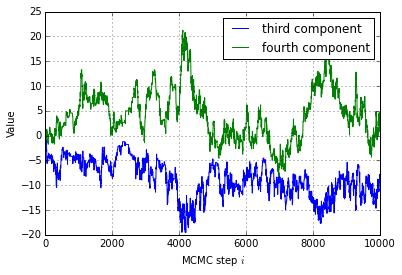

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
l1, = plt.plot(array(theta[2,:])[0])
l2, = plt.plot(array(theta[3,:])[0])
plt.legend([l1,l2],['third component','fourth component'])
plt.grid(True,which="both")
plt.xlabel(r"MCMC step $i$")
plt.ylabel(r"Value")
plt.show()

Also, plot the evolution of the empirical error $r_n(\theta_i)$ as a function of $i\in\{0,\dots,N\}$.

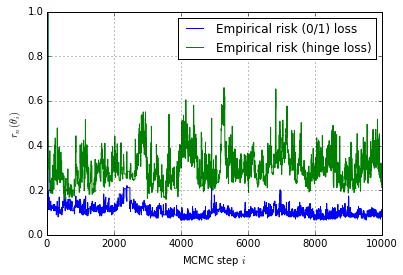

In [52]:
fig = plt.figure()
plt.ylim(0,1)
ax = fig.add_subplot(111)
l1, = plt.plot(err_MCMC)
l2, = plt.plot(err_MCMC_hinge)
plt.legend([l1,l2],['Empirical risk (0/1) loss','Empirical risk (hinge loss)'])
plt.grid(True,which="both")
plt.xlabel(r"MCMC step $i$")
plt.ylabel(r"$r_n(\theta_i)$")
plt.show()

A zoom on the first $50$ steps.

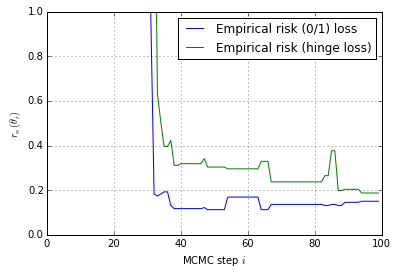

In [54]:
fig = plt.figure()
plt.ylim(0,1)
ax = fig.add_subplot(111)
l1, = plt.plot(err_MCMC[0:100])
l2, = plt.plot(err_MCMC_hinge[0:100])
plt.legend([l1,l2],['Empirical risk (0/1) loss','Empirical risk (hinge loss)'])
plt.grid(True,which="both")
plt.xlabel(r"MCMC step $i$")
plt.ylabel(r"$r_n(\theta_i)$")
plt.show()

**Variational Bayes (VB) approximations**

Idea of VB approximation: introduce a parametric approximation of the distribution $p$, and optimize this approximation with respect to its parameter. So, the problem boils down to a minimization problem. Family of approximation: $(p_{\zeta},\zeta\in S)$. Minimization problem: $\hat{\zeta} =\arg\min_{\zeta\in S} \mathcal{K}(p_{\zeta},p)$.

In practice, we try to approximate the EWA $\hat{\rho}_\lambda$ and we can prove
$$ \hat{\zeta} =\arg\min_{\zeta\in S} \mathcal{K}(p_{\zeta},\hat{\rho}_\lambda) = \arg\min_{\zeta\in S} \left[\int r_n(f_\theta)p_\zeta({\rm d}\theta) + \frac{\mathcal{K}(p_{\zeta},\pi)}{\lambda} \right] .$$

_Theorem_: for any $\varepsilon\in(0,1)$, with probability at least $1-\varepsilon$ we have
$$
\int R(f_\theta) p_{\hat{\zeta}}({\rm d}\theta)
\leq
\inf_{\zeta\in S}
\left\{
\int R(f_\theta) p_\zeta ({\rm d}\theta) + \frac{\lambda C^2}{4n} + 2\frac{\mathcal{K}(p_\zeta,\pi)+\log\left(\frac{2}{\varepsilon}\right)}{\lambda}
\right\}.
$$

_Example_: linear classification $f_{\theta}(x) = \left<\theta,x\right>$, zero/one loss, Gaussian prior $\pi=\mathcal{N}(0,\sigma^2 I_M)$ and Gaussian approximation of the posterior: $\zeta = (m,\tau)$ with $p_{\zeta} = \mathcal{N}(m,\tau^2 I_M)$. Then the variational estimator is defined by
$$
(\hat{m},\hat{\tau}) = \arg\min_{m,\tau} \left\{
-\frac{\lambda}{n}\sum_{i=1}^n \Phi\left(-\frac{Y_i \left<X_i,m\right>}{\tau \|X_i\| }\right) - \frac{\|m\|^2}{2\sigma^2}
 + \frac{M}{2} \left[\log(\tau^2) - \frac{\tau^2}{\sigma^2}\right]
\right\}
$$
where $\Phi$ is the c.d.f of the standard Gaussian random variable. Note that this problem is smooth but non-convex. A convexification is possible (see the references). Finally, the theorem above leads (under additional, but not very restrictive, assumptions of the distribution of $X_i$) to
$$
\int R(f_\theta) p_{(\hat{m},\hat{\tau})}({\rm d}\theta)
\leq
\inf_{m\in \mathbb{R}^M } R(f_m) + \mathcal{C} \sqrt{\frac{M}{n}\log(Mn)} + \mathcal{C} \frac{\log\left(\frac{2}{\varepsilon}\right)}{\sqrt{n}},
$$
for some constant $\mathcal{C}$ (that depends on the distribution of $X_i$), and for an adequate choice of $\lambda$ and $\sigma^2$.

**References**

Good reference:

C. M. Bishop, _Pattern Recognition and Machine Learning_, Springer (2006).

Contains an introduction to VB (Chapter 10) and to MCMC (Chapter 11). The PAC-Bayesian analysis of VB is due to

P. Alquier, J. Ridgway & N. Chopin, On the Properties of Variational Approximations of Gibbs Posteriors, preprint arXiv:1506.04091 (2015).

The theorem on MCMC is taken from a very complete book on the theory of Markov chains (but be careful, it's a rather technical reading!):

S. P. Meyn, R. L. Tweedie, _Markov Chains and Stochastic Stability_, 2nd Edition, Cambridge University Press (2009).